<a href="https://colab.research.google.com/github/SatyamBhawsinghka/LBC_Project/blob/main/NN_based_chatter_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Single Layer FFNN for Chatter Detection
Most  machining  processes  are  subject  to  undesired  vibrations in the  form  of  forced  and  chatter  vibrations  thataffect  the quality  of  the  process.  Although  forced  vibrations  are  a result of  cutting  forces,  chatter  is  self excited form  of  vibration which  grows  exponentially  and  becomes destructive  once  triggered.Chatter  has  detrimental  impactin  the  industry  as  it  becomes  a limiting  factor  and  forcesthe  operation  to  be  performed  at cutting  speeds  below  themachine’s capabilities. Also, these vibrations not only resultin  poor  surface  finish  but  may  also lead  to  tool  breakage. Therefore here a FFNN is deployed which uses acceleration data for the early detection of chatter to prevent the damages it costs. 

# Data Processing

Importing Libraries

In [ ]:
import io
import pandas as pd
from google.colab import files
import numpy
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from scipy import stats

Uploading data file

In [ ]:
uploaded = files.upload()

Saving DataFile.xlsx to DataFile.xlsx


Creating DataFrame


1.   df_flag is the flag that the accelartion data belongs to chattering signal
2.   df_csi is the chatter start time for that signal
3.   df_signal is the acceleration values at particular time intervals
4.   df_time is the time values for which the acceleration data is present













In [ ]:
df = pd.read_excel(io.BytesIO(uploaded.get('DataFile.xlsx')),header=None)


In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
df_flag=df.iloc[0::4,1]
df_flag=df_flag.reset_index().iloc[:,1]

In [ ]:
df_csi=df.iloc[1::4,1]
df_csi=df_csi.reset_index().iloc[:,1]

In [ ]:
df_signal=df.iloc[2::4,:]
df_signal=df_signal.reset_index().iloc[:,2:]

In [ ]:
df_time=df.iloc[3::4,:]
df_time=df_time.reset_index().iloc[:,2:]

In [ ]:
df_chatter_csi = df_csi[df_flag==1]
df_chatter_csi = df_chatter_csi.reset_index().iloc[:,1]
df_chatter_signal = df_signal[df_flag==1]
df_chatter_signal=df_chatter_signal.reset_index().iloc[:,2:]
df_chatter_time = df_time[df_flag==1]
df_chatter_time=df_chatter_time.reset_index().iloc[:,2:]
df_no_chatter_csi = df_csi[df_flag==0]
df_no_chatter_csi = df_no_chatter_csi.reset_index().iloc[:,1]
df_no_chatter_signal = df_signal[df_flag==0]
df_no_chatter_signal=df_no_chatter_signal.reset_index().iloc[:,2:]
df_no_chatter_time = df_time[df_flag==0]
df_no_chatter_time=df_no_chatter_time.reset_index().iloc[:,2:]


Functions to extract acceleration values for desired freq and desired window

In [ ]:
def extract_chatter_data(df_signal,csi,freq,window,gap):
  
  a=[]
  
  for row in range(df_signal.shape[0]):
    b=[]
    signal=df_signal.iloc[row,:]
    
    for x in range(int(csi[row]-window*1000-gap*1000),int(csi[row]-gap*1000),int(freq*1000)):
      #y=round(x/1000, 3)
      c=signal[x]
      #b.append(numpy.round(c.values,2))
      b.append(abs(round(c,2)))
    a.append(b)  

  return a


In [ ]:
def extract_no_chatter_data(df_signal,freq,window):
  
  a=[]
  
  for row in range(df_signal.shape[0]):
    b=[]
    signal=df_signal.iloc[row,:]
    
    for x in range(10,10+int(window*1000),int(freq*1000)):
      #y=round(x/1000, 3)
      c=signal[x]
      #b.append(numpy.round(c.values,2))
      b.append(abs(round(c,2)))
    a.append(b)  

  return a


Function that trains 10 iterations of a model and plots average accuracy and loss scores and saves best model iteration

In [ ]:
def train_model(features,lables,epochs,hidden_layer_units): 
  l = features.shape[1]
  X = features
  y = numpy.ravel(labels)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


  scaler = StandardScaler().fit(X_train)

  X_train = scaler.transform(X_train)

  X_test = scaler.transform(X_test)
  model = Sequential()
  model.add(Dense(hidden_layer_units, activation='relu', input_shape=(l,)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_test, y_test), shuffle=True,verbose=0)
  acc = numpy.array(history.history['accuracy'])
  val_acc = numpy.array(history.history['val_accuracy'])
  loss = numpy.array(history.history['loss'])
  val_loss = numpy.array(history.history['val_loss'])
  score = history.history['accuracy'][99] + history.history['val_accuracy'][99]
  best_score = score
  best_model = model

  
  for x in range(9):
    model = Sequential()
    model.add(Dense(hidden_layer_units, activation='relu', input_shape=(l,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
    #model.fit(X_train, y_train,epochs=epochs, batch_size=1, verbose=0)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_test, y_test), shuffle=True,verbose=0)
    acc = acc + numpy.array(history.history['accuracy'])
    val_acc = val_acc + numpy.array(history.history['val_accuracy'])
    loss = loss + numpy.array(history.history['loss'])
    val_loss = val_loss + numpy.array(history.history['val_loss'])
    score = history.history['accuracy'][99] + history.history['val_accuracy'][99]
    if score>best_score:
      best_score = score
      best_model = model

  plt.plot(acc/10)
  plt.plot(val_acc/10)
  plt.title('Training progress by mean model accuracy over 10 iterations')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()
  
  plt.plot(loss/10)
  plt.plot(val_loss/10)
  plt.title('Mean model loss over 10 iterations')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()
  print('Results from best model')
  print('Train')
  score_train = best_model.evaluate(X_train, y_train,verbose=1)
  print('Test')
  score_test = best_model.evaluate(X_test, y_test,verbose=1)

  return best_model
  
  

In [ ]:
  # plt.plot(history.history['accuracy'])
  # plt.plot(history.history['val_accuracy'])
  # plt.title('model accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'val'], loc='upper left')
  # plt.show()
  # plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  # plt.title('model loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'val'], loc='upper left')
  # plt.show()
  # print('Train')
  # score_train = model.evaluate(X_train, y_train,verbose=1)
  # print('Test')
  # score_test = model.evaluate(X_test, y_test,verbose=1)

#Prelimnary Models

Preliminary model training to establish hidden layer units

## Window Size=0.20 s, Freq= 10 ms, no gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)

In [ ]:
a['label']=1
b['label']=0

In [ ]:
new_df=a.append(b)

In [ ]:
labels=new_df['label']
features = new_df.iloc[:,0:20]

Optimising number of hidden layer units

In [ ]:
for x in range(1,10):
  print('for number of hidden layer units=',x)
  train_model(features,labels,100,x)

for number of hidden layer units= 1
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.5478 - accuracy: 0.7203
Test
7/7 [==============================] - 0s 6ms/step - loss: 0.5851 - accuracy: 0.6830
for number of hidden layer units= 2
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.4939 - accuracy: 0.7644
Test
7/7 [==============================] - 0s 4ms/step - loss: 0.7270 - accuracy: 0.7232
for number of hidden layer units= 3
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.3157 - accuracy: 0.8697
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.7991
for number of hidden layer units= 4
Train
17/17 [==============================] - 0s 3ms/step - loss: 0.3302 - accuracy: 0.8602
Test
7/7 [==============================] - 0s 4ms/step - loss: 0.5204 - accuracy: 0.8125
for number of hidden layer units= 5
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.2168 - accuracy: 0.

In [ ]:
for x in range(10,16):
  print('for number of hidden layer units=',x)
  train_model(features,labels,100,x)

for number of hidden layer units= 10
Train
17/17 [==============================] - 1s 2ms/step - loss: 0.2244 - accuracy: 0.9061
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.4240 - accuracy: 0.8125
for number of hidden layer units= 11
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1188 - accuracy: 0.9617
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.4737 - accuracy: 0.8884
for number of hidden layer units= 12
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1144 - accuracy: 0.9636
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.2940 - accuracy: 0.8750
for number of hidden layer units= 13
Train
17/17 [==============================] - 0s 1ms/step - loss: 0.1456 - accuracy: 0.9330
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.5020 - accuracy: 0.8348
for number of hidden layer units= 14
Train
17/17 [==============================] - 0s 1ms/step - loss: 0.1528 - accurac

Number of hidden layer units fixed at 11, max epochs 100, 1 hidden layer with relu activation and output layer sigmoid

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
train_model(features,labels,100,11)

Train
17/17 [==============================] - 0s 1ms/step - loss: 0.1534 - accuracy: 0.9272
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.4770 - accuracy: 0.8304


(<keras.engine.sequential.Sequential at 0x7f1d7b086890>,
 [0.3556843101978302, 0.875])

##Window Size=0.20 s, Freq= 10 ms, 0.2s gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0.2)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
train_model(features,labels,100,11)

Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9291
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.5920 - accuracy: 0.8393


(<keras.engine.sequential.Sequential at 0x7f1d78c54cd0>,
 [0.3556843101978302, 0.875])

##Window Size=0.20 s, Freq= 10 ms, 0.4s gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0.4)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
train_model(features,labels,100,11)

NameError: ignored

##Window Size=0.20 s, Freq= 5 ms, no gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
train_model(features,labels,100,11)

NameError: ignored

##Window Size=0.20 s, Freq= 5 ms, 0.2s gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0.2)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
train_model(features,labels,100,11)

Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1375 - accuracy: 0.9444
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.9155 - accuracy: 0.7946


(<keras.engine.sequential.Sequential at 0x7f1d79a9eb10>,
 [0.3556843101978302, 0.875])

##Window Size=0.20 s, Freq= 5 ms, 0.4s gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0.4)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
train_model(features,labels,100,11)

Train
17/17 [==============================] - 0s 1ms/step - loss: 0.0869 - accuracy: 0.9598
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.3639 - accuracy: 0.8795


(<keras.engine.sequential.Sequential at 0x7f1d70bf46d0>,
 [0.3556843101978302, 0.875])

#Plots over 10 iterations of the model

Window Size=0.20 s, Freq= 10 ms, no gap

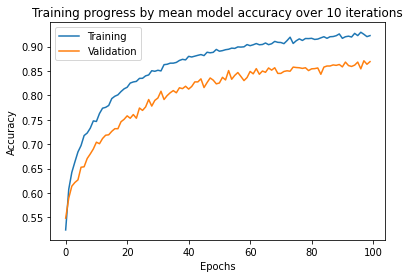

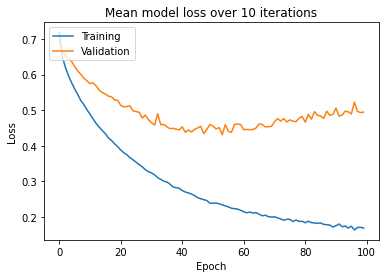

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1415 - accuracy: 0.9464
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.4850 - accuracy: 0.8929


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
model1 = train_model(features,labels,100,11)


In [ ]:
model1.save('model1.h5') 
# new_model = tf.keras.models.load_model('my_model.h5')

Window Size=0.20 s, Freq= 10 ms, 0.2s gap

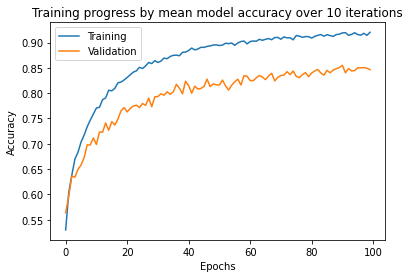

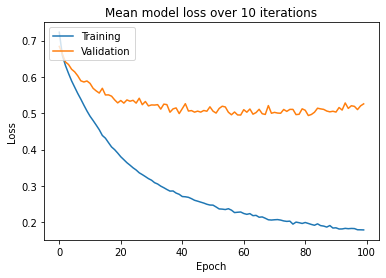

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1553 - accuracy: 0.9215
Test
7/7 [==============================] - 0s 4ms/step - loss: 0.4524 - accuracy: 0.8839


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0.2)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
model2 = train_model(features,labels,100,11)
model2.save('model2.h5') 

Window Size=0.20 s, Freq= 10 ms, 0.4s gap

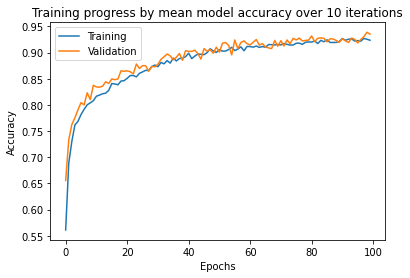

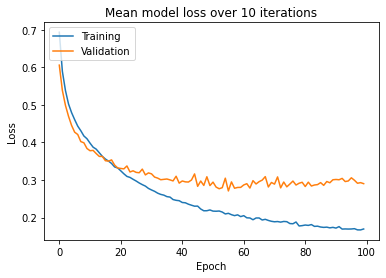

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1470 - accuracy: 0.9349
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.3051 - accuracy: 0.9420


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0.4)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
model3 = train_model(features,labels,100,11)
model3.save('model3.h5') 

Window Size=0.20 s, Freq= 5 ms, no gap

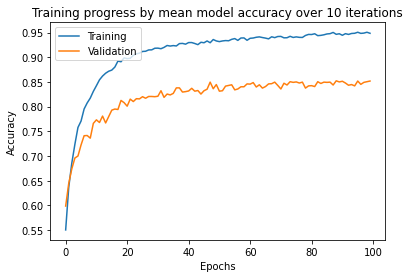

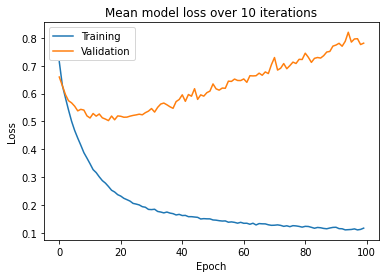

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.0907 - accuracy: 0.9617
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.9042 - accuracy: 0.8839


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
model4=train_model(features,labels,100,11)
model4.save('model4.h5') 

Window Size=0.20 s, Freq= 5 ms, 0.2s gap

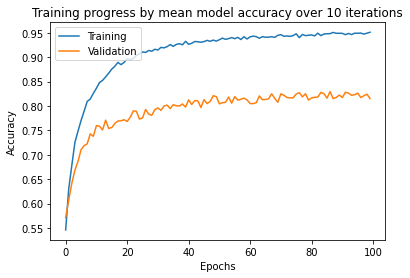

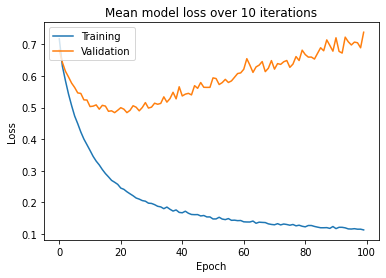

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.9655
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.4762 - accuracy: 0.8438


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0.2)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
model5=train_model(features,labels,100,11)
model5.save('model5.h5') 

Window Size=0.20 s, Freq= 5 ms, 0.4s gap

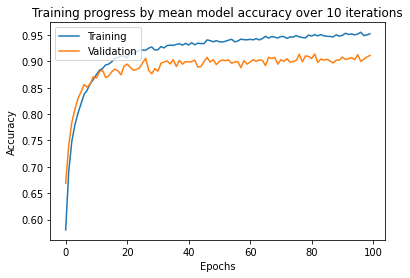

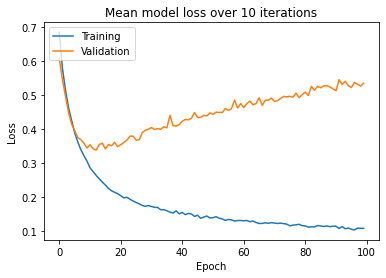

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.0869 - accuracy: 0.9521
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.4028 - accuracy: 0.9196


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0.4)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
model6=train_model(features,labels,100,11)
model6.save('model6.h5')

#Retrain the model


Repeating the process to check for consistency

Window Size=0.20 s, Freq= 10 ms, No gap

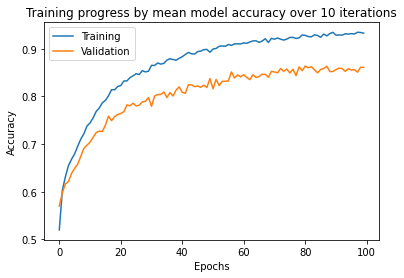

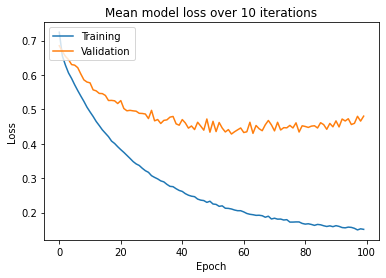

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 0.9502
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.4140 - accuracy: 0.8884


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
model1 = train_model(features,labels,100,11)
model1.save('/content/drive/MyDrive/models/LBC_Project/model1.h5') 

Window Size=0.20 s, Freq= 10 ms, 0.2s gap

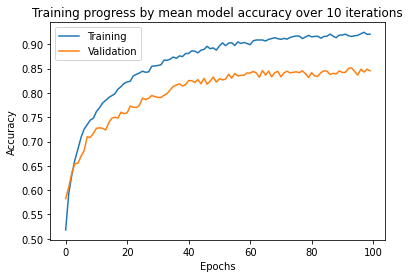

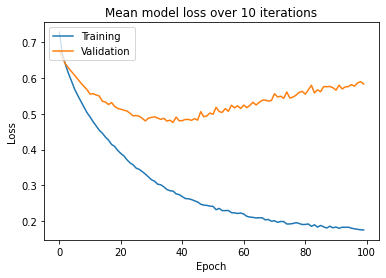

Results from best model
Train
17/17 [==============================] - 0s 3ms/step - loss: 0.1379 - accuracy: 0.9406
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.5284 - accuracy: 0.8616


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0.2)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
model2 = train_model(features,labels,100,11)
model2.save('/content/drive/MyDrive/models/LBC_Project/model2.h5') 

Window Size=0.20 s, Freq= 10 ms, 0.4s gap

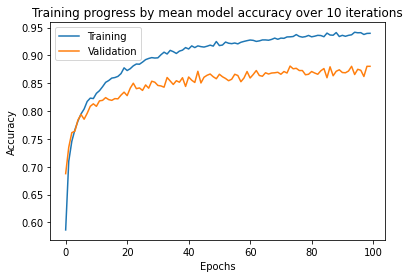

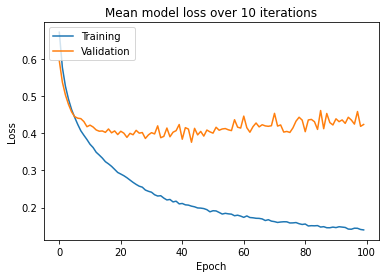

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.0989 - accuracy: 0.9751
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.3688 - accuracy: 0.9107


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0.4)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
model3 = train_model(features,labels,100,11)


In [ ]:
model3.save('/content/drive/MyDrive/models/LBC_Project/model3.h5') 


Window Size=0.20 s, Freq= 5 ms, No gap

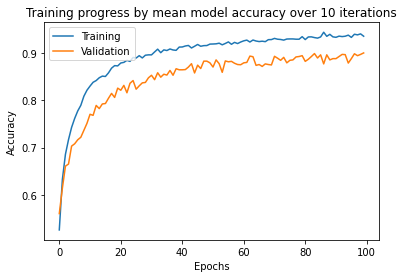

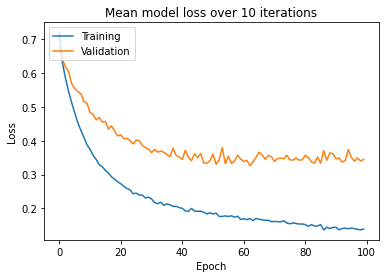

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.1190 - accuracy: 0.9387
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.3267 - accuracy: 0.9420


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
model4=train_model(features,labels,100,11)
model4.save('/content/drive/MyDrive/models/LBC_Project/model4.h5') 

Window Size=0.20 s, Freq= 5 ms, 0.2s gap

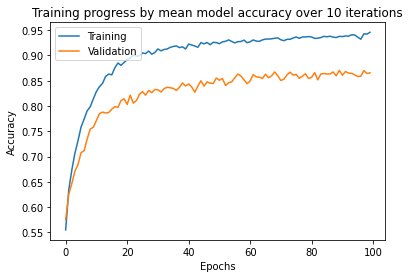

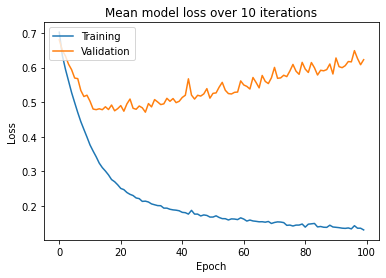

Results from best model
Train
17/17 [==============================] - 0s 3ms/step - loss: 0.0959 - accuracy: 0.9559
Test
7/7 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.8839


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0.2)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
model5=train_model(features,labels,100,11)
model5.save('/content/drive/MyDrive/models/LBC_Project/model5.h5')

Window Size=0.20 s, Freq= 5 ms, 0.4s gap

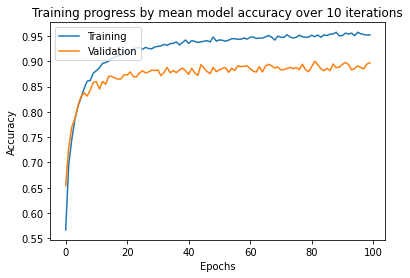

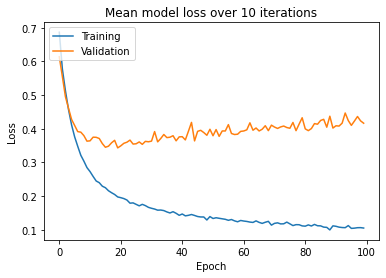

Results from best model
Train
17/17 [==============================] - 0s 2ms/step - loss: 0.0736 - accuracy: 0.9732
Test
7/7 [==============================] - 0s 2ms/step - loss: 0.3295 - accuracy: 0.9152


In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0.4)
a=pd.DataFrame(a)
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
a['label']=1
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
model6=train_model(features,labels,100,11)


In [ ]:
model6.save('/content/drive/MyDrive/models/LBC_Project/model6.h5') 

#Correlation between datasets and label

Checking the correlation between different datasets and classification variable

window size=0.2s, freq=0.01s

No gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0)
a=pd.DataFrame(a)
a['label']=1
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
scaler = StandardScaler().fit(features)
features = scaler.transform(features)
corr_list = []
for i in range(20):
    x=features[:,i]
    corr = stats.pointbiserialr(list(x),list(labels))
    corr_list.append(abs(corr[0]))
    
print(corr_list)
print(sum(corr_list)/len(corr_list))


[0.22250878224797485, 0.030647193871595656, 0.04789962029536967, 0.024099830817524894, 0.015095794397958532, 0.03326794704375548, 0.02960785708076423, 0.022135307507346165, 0.01988092254093074, 0.07275902990232068, 0.03772548090220827, 0.09524699224320293, 0.018363837047971367, 0.03556733279904922, 0.007104211198168683, 0.0690621921945426, 0.016214178746597356, 0.07817080536692411, 0.001432275955657428, 0.036021937808379825]
0.04564057649841213


0.2s gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0.2)
a=pd.DataFrame(a)
a['label']=1
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
scaler = StandardScaler().fit(features)
features = scaler.transform(features)
corr_list = []
for i in range(20):
    x=features[:,i]
    corr = stats.pointbiserialr(list(x),list(labels))
    corr_list.append(abs(corr[0]))
    
print(corr_list)
print(sum(corr_list)/len(corr_list))

[0.20105015951624317, 0.027928514964663136, 0.03244705236541734, 0.006651014112569827, 0.0025399334501732622, 0.02107355105389694, 0.011491031651203359, 0.04188026969938344, 0.04451333758697974, 0.07243341152111966, 0.008571051701521164, 0.048994498191590956, 0.022415329421611896, 0.01758386856713247, 0.029308388194846952, 0.09693420719835207, 0.0012563608782964633, 0.0351822462970065, 0.037290734333470216, 0.021723192411310512]
0.03906340765583945


0.4s gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.01,0.2,0.4)
a=pd.DataFrame(a)
a['label']=1
b=extract_no_chatter_data(df_chatter_signal,0.01,0.2)
b=pd.DataFrame(b)
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:20]
scaler = StandardScaler().fit(features)
features = scaler.transform(features)
corr_list = []
for i in range(20):
    x=features[:,i]
    corr = stats.pointbiserialr(list(x),list(labels))
    corr_list.append(abs(corr[0]))
    
print(corr_list)
print(sum(corr_list)/len(corr_list))

[0.20252659685947036, 0.04292874471694414, 0.01469047506968248, 0.04212507227210583, 0.014517209025376301, 0.019479345226791116, 0.008179435665557507, 0.026782619506364614, 0.05235282742286269, 0.08576722212809558, 0.417026079293074, 0.08326760556451752, 0.006136190912092873, 0.013268688402542191, 0.01610536698646102, 0.011670559762512557, 0.049654708343170935, 0.009257593843335984, 0.034122528793997, 0.012996318858823389]
0.05814275943268891


window size=0.2s, freq=0.005s

No gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0)
a=pd.DataFrame(a)
a['label']=1
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
scaler = StandardScaler().fit(features)
features = scaler.transform(features)
corr_list = []
for i in range(40):
    x=features[:,i]
    corr = stats.pointbiserialr(list(x),list(labels))
    corr_list.append(abs(corr[0]))
    
print(corr_list)
print(sum(corr_list)/len(corr_list))


[0.22250878224797485, 0.00886642160201394, 0.030647193871595656, 0.11702960405381554, 0.04789962029536967, 0.04635899343259498, 0.024099830817524894, 0.047764391639537815, 0.015095794397958532, 0.0707917869666451, 0.03326794704375548, 0.032145146674897276, 0.02960785708076423, 0.007998271621065442, 0.022135307507346165, 0.07673679350429123, 0.01988092254093074, 0.017061690103309234, 0.07275902990232068, 0.010052617147888222, 0.03772548090220827, 0.07339070273491774, 0.09524699224320293, 0.03711725350680962, 0.018363837047971367, 0.021601983848122338, 0.03556733279904922, 0.006208083349944887, 0.007104211198168683, 0.04165243388020591, 0.0690621921945426, 0.06338597472130642, 0.016214178746597356, 0.02655376896795062, 0.07817080536692411, 0.07288180839175519, 0.001432275955657428, 0.03740274516847516, 0.036021937808379825, 0.13451097089983613]
0.04655807430459064


0.2s gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0.2)
a=pd.DataFrame(a)
a['label']=1
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
scaler = StandardScaler().fit(features)
features = scaler.transform(features)
corr_list = []
for i in range(40):
    x=features[:,i]
    corr = stats.pointbiserialr(list(x),list(labels))
    corr_list.append(abs(corr[0]))
    
print(corr_list)
print(sum(corr_list)/len(corr_list))

[0.20105015951624317, 0.007803700840102697, 0.027928514964663136, 0.1272021365329113, 0.03244705236541734, 0.03420594078962531, 0.006651014112569827, 0.015077185108868489, 0.0025399334501732622, 0.06865654203181383, 0.02107355105389694, 0.027874662158796335, 0.011491031651203359, 0.043787482397231715, 0.04188026969938344, 0.1008071961857592, 0.04451333758697974, 0.018210688861930592, 0.07243341152111966, 0.04550407301354294, 0.008571051701521164, 0.0012986537133109978, 0.048994498191590956, 0.1258364633809396, 0.022415329421611896, 0.030119855979967768, 0.01758386856713247, 0.0028848958624702278, 0.029308388194846952, 0.03049063139312644, 0.09693420719835207, 0.04319521605429838, 0.0012563608782964633, 0.044518512790776885, 0.0351822462970065, 0.01811135330548674, 0.037290734333470216, 0.04844249048272158, 0.021723192411310512, 0.019357198182886667]
0.04086632580458392


0.4s gap

In [ ]:
a=extract_chatter_data(df_chatter_signal,df_chatter_csi,0.005,0.2,0.4)
a=pd.DataFrame(a)
a['label']=1
b=extract_no_chatter_data(df_chatter_signal,0.005,0.2)
b=pd.DataFrame(b)
b['label']=0
new_df=a.append(b)
labels=new_df['label']
features = new_df.iloc[:,0:40]
scaler = StandardScaler().fit(features)
features = scaler.transform(features)
corr_list = []
for i in range(40):
    x=features[:,i]
    corr = stats.pointbiserialr(list(x),list(labels))
    corr_list.append(abs(corr[0]))
    
print(corr_list)
print(sum(corr_list)/len(corr_list))

[0.20252659685947036, 0.023711040740695088, 0.04292874471694414, 0.09005303427601588, 0.01469047506968248, 0.015310913020241373, 0.04212507227210583, 0.023715880520456596, 0.014517209025376301, 0.05357247766817008, 0.019479345226791116, 0.023873785511340718, 0.008179435665557507, 0.0191149794716161, 0.026782619506364614, 0.039488404941280184, 0.05235282742286269, 0.007206433186022244, 0.08576722212809558, 0.018047330238890463, 0.417026079293074, 0.03910971963969672, 0.08326760556451752, 0.0494863719502454, 0.006136190912092873, 0.019837908156667246, 0.013268688402542191, 0.0012936335727282305, 0.01610536698646102, 0.06922711754557742, 0.011670559762512557, 0.13202834195040627, 0.049654708343170935, 0.007861465323249084, 0.009257593843335984, 0.0208654648295956, 0.034122528793997, 0.00938686841116235, 0.012996318858823389, 0.02519661442607765]
0.04628107435084782


#Real Time Data


Checking the performance on data from real experiments

## Processing


In [ ]:
uploaded = files.upload()

Saving Data_RT_new.xlsx to Data_RT_new.xlsx


In [ ]:
df1 = pd.read_excel(io.BytesIO(uploaded.get('Data_RT_new.xlsx')),header=None)

In [ ]:
df = pd.read_excel(io.BytesIO(uploaded.get('Data_RT.xlsx')),header=None)

In [ ]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-33.763154,7.5999,NaN,303.432317,7.5999,NaN,159.756011,7.4999,NaN,10.934713,7.3999,NaN,-1587.936172,7.4999
1,-63.106979,7.6000,NaN,200.728929,7.6000,NaN,13.036885,7.5000,NaN,-18.409112,7.4000,NaN,-2160.140762,7.5000
2,-77.778892,7.6001,NaN,112.697454,7.6001,NaN,-16.306940,7.5001,NaN,-18.409112,7.4001,NaN,-2336.203712,7.5001
3,-4.419329,7.6002,NaN,-78.037410,7.6002,NaN,-16.306940,7.5002,NaN,10.934713,7.4002,NaN,-2321.531800,7.5002
4,-33.763154,7.6003,NaN,-180.740798,7.6003,NaN,13.036885,7.5003,NaN,25.606626,7.4003,NaN,-2086.781199,7.5003


In [ ]:
df1[0].last_valid_index()

190000

In [ ]:
df1[3].last_valid_index()

131000

In [ ]:
df1[6].last_valid_index()

128000

In [ ]:
df1[9].last_valid_index()

133000

In [ ]:
df1[12].last_valid_index()

189000

In [ ]:
df=df.T

In [ ]:
df1=df1.T

In [ ]:
y1=df.iloc[0:2,0:74319]

In [ ]:
y1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,74279,74280,74281,74282,74283,74284,74285,74286,74287,74288,74289,74290,74291,74292,74293,74294,74295,74296,74297,74298,74299,74300,74301,74302,74303,74304,74305,74306,74307,74308,74309,74310,74311,74312,74313,74314,74315,74316,74317,74318
0,0.000000,0.000100,0.000200,0.000300,0.000400,0.00050,0.000600,0.000700,0.000800,0.000900,0.001000,0.001100,0.00120,0.001300,0.001400,0.001500,0.001600,0.001700,0.001800,0.001900,0.002000,0.002100,0.002200,0.002300,0.002400,0.002500,0.002600,0.002700,0.0028,0.002900,0.003000,0.003100,0.003200,0.003300,0.003400,0.003500,0.003600,0.003700,0.003800,0.003900,...,7.427900,7.428000,7.428100,7.428200,7.428300,7.428400,7.428500,7.42860,7.428700,7.428800,7.428900,7.429000,7.429100,7.429200,7.429300,7.429400,7.429500,7.42960,7.429700,7.429800,7.429900,7.43000,7.430100,7.43020,7.430300,7.430400,7.430500,7.430600,7.430700,7.430800,7.430900,7.431000,7.431100,7.431200,7.431300,7.431400,7.431500,7.431600,7.431700,7.431800
1,-1070.214161,-397.159465,146.786409,743.514661,1932.930296,956.93665,-2548.108252,-2089.637163,389.134498,-592.401494,405.930117,3178.644405,560.16726,-1032.229449,-44.884904,-996.003009,-710.100399,1405.495067,793.231149,9.496138,330.953917,-5.952811,-22.244776,-383.760521,180.866816,974.491082,-751.205208,-1275.933428,364.3102,-291.957626,-89.405319,864.611516,466.210596,373.448148,255.950622,-1010.128786,-1417.888789,-23.882135,1285.106881,93.332758,...,2333.103075,2.249522,-2771.168558,1211.047322,2028.543005,-3866.344925,715.396145,4534.51264,-3025.450428,-852.494195,4286.527578,-2952.051863,-1052.767836,7261.856847,-2427.834896,-5151.184719,5354.360422,230.48167,-6035.689463,3423.991627,2746.716516,-5174.71634,1618.513535,3573.82233,-4898.749923,-850.259371,5196.822296,-2201.916936,-3455.635982,3231.542771,-243.926764,-3679.226461,1511.436272,1783.415646,-691.179398,485.915673,1065.190947,-543.138346,-1055.609946,214.432093


In [ ]:
y1.shape[1]

74319

In [ ]:
y2=df.iloc[3:,:].reset_index().iloc[:,1:]

In [ ]:
y2.iloc[0]=y2.iloc[0]-y2.iloc[0,0]

In [ ]:
y2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,234219,234220,234221,234222,234223,234224,234225,234226,234227,234228,234229,234230,234231,234232,234233,234234,234235,234236,234237,234238,234239,234240,234241,234242,234243,234244,234245,234246,234247,234248,234249,234250,234251,234252,234253,234254,234255,234256,234257,234258
0,0.000000,0.000100,0.000200,0.000300,0.00040,0.000500,0.000600,0.000700,0.00080,0.000900,0.001000,0.00110,0.001200,0.001300,0.001400,0.001500,0.001600,0.00170,0.001800,0.00190,0.002000,0.002100,0.002200,0.002300,0.002400,0.00250,0.002600,0.002700,0.002800,0.002900,0.003000,0.003100,0.003200,0.003300,0.003400,0.003500,0.003600,0.003700,0.003800,0.003900,...,23.421900,23.422000,23.422100,23.422200,23.422300,23.422400,23.42250,23.422600,23.42270,23.42280,23.422900,23.423000,23.423100,23.423200,23.423300,23.423400,23.42350,23.423600,23.423700,23.423800,23.423900,23.424000,23.42410,23.424200,23.424300,23.424400,23.424500,23.424600,23.424700,23.42480,23.424900,23.425000,23.425100,23.425200,23.425300,23.425400,23.425500,23.425600,23.425700,23.425800
1,-0.880198,-0.880198,-0.880198,-0.880198,-15.55211,-30.224023,-30.224023,-0.880198,-15.55211,-44.895935,13.791715,-15.55211,-0.880198,-118.255498,-323.662274,-367.678012,-441.037574,-529.06905,-558.412875,-529.06905,-367.678012,-176.943148,-59.567848,175.182753,395.261441,615.34013,659.355868,644.683955,512.636742,409.933354,263.214228,-59.567848,-308.990361,-441.037574,-441.037574,-323.662274,-250.302711,-132.927411,116.495103,424.605267,...,13.791715,28.463627,-0.880198,13.791715,28.463627,28.463627,43.13554,-0.880198,43.13554,-15.55211,13.791715,13.791715,13.791715,13.791715,-30.224023,28.463627,-15.55211,28.463627,28.463627,28.463627,28.463627,28.463627,-15.55211,-30.224023,13.791715,-0.880198,-0.880198,28.463627,28.463627,43.13554,28.463627,13.791715,28.463627,28.463627,28.463627,13.791715,28.463627,28.463627,-0.880198,-0.880198


In [ ]:
y3=df1.iloc[0:2,:].reset_index().iloc[:,1:]
y3.iloc[1]=y3.iloc[1]-y3.iloc[1,0]
y4=df1.iloc[3:5,:131000].reset_index().iloc[:,1:]
y4.iloc[1]=y4.iloc[1]-y4.iloc[1,0]
y5=df1.iloc[6:8,:128000].reset_index().iloc[:,1:]
y5.iloc[1]=y5.iloc[1]-y5.iloc[1,0]
y6=df1.iloc[9:11,:133000].reset_index().iloc[:,1:]
y6.iloc[1]=y6.iloc[1]-y6.iloc[1,0]
y7=df1.iloc[12:,:189000].reset_index().iloc[:,1:]
y7.iloc[1]=y7.iloc[1]-y7.iloc[1,0]

In [ ]:
def extract_rt_test_data(y,freq,window):
  
  a=[]
  c=[]
  for i in range(5000,y.shape[1]-int(window*10000),10):
    b=[]
    
    
    for j in range(i,i+int(window*10000),int(freq*10000)):
      b.append(abs(round(y.iloc[1,j],2)))
      
    a.append(b)
    c.append(y.iloc[0,j])  
  
  a=pd.DataFrame(a)
  c=pd.DataFrame(c)
  return a,c


In [ ]:
def extract_rt_test_data_new(y,freq,window):
  
  a=[]
  c=[]
  for i in range(5000,y.shape[1]-int(window*10000),10):
    b=[]
    
    
    for j in range(i,i+int(window*10000),int(freq*10000)):
      b.append(abs(round(y.iloc[0,j],2)))
      
    a.append(b)
    c.append(y.iloc[1,j])  
  
  a=pd.DataFrame(a)
  c=pd.DataFrame(c)
  return a,c


In [ ]:
Exp1_10_f, Exp1_10_t = extract_rt_test_data(y1,0.01,0.2)
Exp1_5_f, Exp1_5_t = extract_rt_test_data(y1,0.005,0.2)
Exp2_10_f, Exp2_10_t = extract_rt_test_data(y2,0.01,0.2)
Exp2_5_f, Exp2_5_t = extract_rt_test_data(y2,0.005,0.2)

In [ ]:
Exp3_10_f, Exp3_10_t = extract_rt_test_data_new(y3,0.01,0.2)
Exp3_5_f, Exp3_5_t = extract_rt_test_data_new(y3,0.005,0.2)
Exp4_10_f, Exp4_10_t = extract_rt_test_data_new(y4,0.01,0.2)
Exp4_5_f, Exp4_5_t = extract_rt_test_data_new(y4,0.005,0.2)
Exp5_10_f, Exp5_10_t = extract_rt_test_data_new(y5,0.01,0.2)
Exp5_5_f, Exp5_5_t = extract_rt_test_data_new(y5,0.005,0.2)
Exp6_10_f, Exp6_10_t = extract_rt_test_data_new(y6,0.01,0.2)
Exp6_5_f, Exp6_5_t = extract_rt_test_data_new(y6,0.005,0.2)
Exp7_10_f, Exp7_10_t = extract_rt_test_data_new(y7,0.01,0.2)
Exp7_5_f, Exp7_5_t = extract_rt_test_data_new(y7,0.005,0.2)

##Loading Models

In [ ]:
load_model6 = tf.keras.models.load_model('/content/drive/MyDrive/models/LBC_Project/model6.h5')

In [ ]:
load_model3 = tf.keras.models.load_model('/content/drive/MyDrive/models/LBC_Project/model3.h5')


In [ ]:
load_model1 = tf.keras.models.load_model('/content/drive/MyDrive/models/LBC_Project/model1.h5')
load_model2 = tf.keras.models.load_model('/content/drive/MyDrive/models/LBC_Project/model2.h5')
load_model4 = tf.keras.models.load_model('/content/drive/MyDrive/models/LBC_Project/model4.h5')
load_model5 = tf.keras.models.load_model('/content/drive/MyDrive/models/LBC_Project/model5.h5')

##Prediction 

In [ ]:
scaler = StandardScaler().fit(Exp1_10_f)
Exp1_10_f = scaler.transform(Exp1_10_f)
scaler = StandardScaler().fit(Exp1_5_f)
Exp1_5_f = scaler.transform(Exp1_5_f)
scaler = StandardScaler().fit(Exp2_10_f)
Exp2_10_f = scaler.transform(Exp2_10_f)
scaler = StandardScaler().fit(Exp2_5_f)
Exp2_5_f = scaler.transform(Exp2_5_f)

In [ ]:
scaler = StandardScaler().fit(Exp3_10_f)
Exp3_10_f = scaler.transform(Exp3_10_f)
scaler = StandardScaler().fit(Exp3_5_f)
Exp3_5_f = scaler.transform(Exp3_5_f)
scaler = StandardScaler().fit(Exp4_10_f)
Exp4_10_f = scaler.transform(Exp4_10_f)
scaler = StandardScaler().fit(Exp4_5_f)
Exp4_5_f = scaler.transform(Exp4_5_f)
scaler = StandardScaler().fit(Exp5_10_f)
Exp5_10_f = scaler.transform(Exp5_10_f)
scaler = StandardScaler().fit(Exp5_5_f)
Exp5_5_f = scaler.transform(Exp5_5_f)
scaler = StandardScaler().fit(Exp6_10_f)
Exp6_10_f = scaler.transform(Exp6_10_f)
scaler = StandardScaler().fit(Exp6_5_f)
Exp6_5_f = scaler.transform(Exp6_5_f)
scaler = StandardScaler().fit(Exp7_10_f)
Exp7_10_f = scaler.transform(Exp7_10_f)
scaler = StandardScaler().fit(Exp7_5_f)
Exp7_5_f = scaler.transform(Exp7_5_f)

In [ ]:
pred_m1_e1 = pd.DataFrame(load_model1.predict(Exp1_10_f))

In [ ]:
Exp1_10_t.iloc[pred_m1_e1.idxmax()]

,0
5,0.695


In [ ]:
pred_m1_e2 = pd.DataFrame(load_model1.predict(Exp2_10_f))

In [ ]:
Exp2_10_t.iloc[pred_m1_e2.idxmax()]

,0
11360,12.05


In [ ]:
pred_m2_e1 = pd.DataFrame(load_model2.predict(Exp1_10_f))
print('Model 2 exp1')
print(Exp1_10_t.iloc[pred_m2_e1.idxmax()])
pred_m2_e2 = pd.DataFrame(load_model2.predict(Exp2_10_f))
print('Model 2 exp2')
print(Exp2_10_t.iloc[pred_m2_e2.idxmax()])
pred_m3_e1 = pd.DataFrame(load_model3.predict(Exp1_10_f))
print('Model 3 exp1')
print(Exp1_10_t.iloc[pred_m3_e1.idxmax()])
pred_m3_e2 = pd.DataFrame(load_model3.predict(Exp2_10_f))
print('Model 3 exp2')
print(Exp2_10_t.iloc[pred_m3_e2.idxmax()])
pred_m4_e1 = pd.DataFrame(load_model4.predict(Exp1_5_f))
print('Model 4 exp1')
print(Exp1_5_t.iloc[pred_m4_e1.idxmax()])
pred_m4_e2 = pd.DataFrame(load_model4.predict(Exp2_5_f))
print('Model 4 exp2')
print(Exp2_5_t.iloc[pred_m4_e2.idxmax()])
pred_m5_e1 = pd.DataFrame(load_model5.predict(Exp1_5_f))
print('Model 5 exp1')
print(Exp1_5_t.iloc[pred_m5_e1.idxmax()])
pred_m5_e2 = pd.DataFrame(load_model5.predict(Exp2_5_f))
print('Model 5 exp2')
print(Exp2_5_t.iloc[pred_m5_e2.idxmax()])
pred_m6_e1 = pd.DataFrame(load_model6.predict(Exp1_5_f))
print('Model 6 exp1')
print(Exp1_5_t.iloc[pred_m6_e1.idxmax()])
pred_m6_e2 = pd.DataFrame(load_model6.predict(Exp2_5_f))
print('Model 6 exp2')
print(Exp2_5_t.iloc[pred_m6_e2.idxmax()])


Predictions for Exp3 

In [ ]:
pred_m1_e3 = pd.DataFrame(load_model1.predict(Exp3_10_f))
print('Model 1')
print(Exp3_10_t.iloc[pred_m1_e3.idxmax()])
pred_m2_e3 = pd.DataFrame(load_model2.predict(Exp3_10_f))
print('Model 2')
print(Exp3_10_t.iloc[pred_m2_e3.idxmax()])
pred_m3_e3 = pd.DataFrame(load_model3.predict(Exp3_10_f))
print('Model 3')
print(Exp3_10_t.iloc[pred_m3_e3.idxmax()])
pred_m4_e3 = pd.DataFrame(load_model4.predict(Exp3_5_f))
print('Model 4')
print(Exp3_5_t.iloc[pred_m4_e3.idxmax()])
pred_m5_e3 = pd.DataFrame(load_model5.predict(Exp3_5_f))
print('Model 5')
print(Exp3_5_t.iloc[pred_m5_e3.idxmax()])
pred_m6_e3 = pd.DataFrame(load_model6.predict(Exp3_5_f))
print('Model 6')
print(Exp3_5_t.iloc[pred_m6_e3.idxmax()])

Model 1
            0
11351  12.041
Model 2
            0
11398  12.088
Model 3
            0
11478  12.168
Model 4
            0
11513  12.208
Model 5
            0
11531  12.226
Model 6
           0
11435  12.13


Predictions for Exp4 

In [ ]:
pred_m1_e4 = pd.DataFrame(load_model1.predict(Exp4_10_f))
print('Model 1')
print(Exp4_10_t.iloc[pred_m1_e4.idxmax()])
pred_m2_e4 = pd.DataFrame(load_model2.predict(Exp4_10_f))
print('Model 2')
print(Exp4_10_t.iloc[pred_m2_e4.idxmax()])
pred_m3_e4 = pd.DataFrame(load_model3.predict(Exp4_10_f))
print('Model 3')
print(Exp4_10_t.iloc[pred_m3_e4.idxmax()])
pred_m4_e4 = pd.DataFrame(load_model4.predict(Exp4_5_f))
print('Model 4')
print(Exp4_5_t.iloc[pred_m4_e4.idxmax()])
pred_m5_e4 = pd.DataFrame(load_model5.predict(Exp4_5_f))
print('Model 5')
print(Exp4_5_t.iloc[pred_m5_e4.idxmax()])
pred_m6_e4 = pd.DataFrame(load_model6.predict(Exp4_5_f))
print('Model 6')
print(Exp4_5_t.iloc[pred_m6_e4.idxmax()])

Model 1
          0
5483  6.173
Model 2
          0
5781  6.471
Model 3
          0
3973  4.663
Model 4
          0
5436  6.131
Model 5
          0
5429  6.124
Model 6
          0
5436  6.131


Predictions for Exp5 

In [ ]:
pred_m1_e5 = pd.DataFrame(load_model1.predict(Exp5_10_f))
print('Model 1')
print(Exp5_10_t.iloc[pred_m1_e5.idxmax()])
pred_m2_e5 = pd.DataFrame(load_model2.predict(Exp5_10_f))
print('Model 2')
print(Exp5_10_t.iloc[pred_m2_e5.idxmax()])
pred_m3_e5 = pd.DataFrame(load_model3.predict(Exp5_10_f))
print('Model 3')
print(Exp5_10_t.iloc[pred_m3_e5.idxmax()])
pred_m4_e5 = pd.DataFrame(load_model4.predict(Exp5_5_f))
print('Model 4')
print(Exp5_5_t.iloc[pred_m4_e5.idxmax()])
pred_m5_e5 = pd.DataFrame(load_model5.predict(Exp5_5_f))
print('Model 5')
print(Exp5_5_t.iloc[pred_m5_e5.idxmax()])
pred_m6_e5 = pd.DataFrame(load_model6.predict(Exp5_5_f))
print('Model 6')
print(Exp5_5_t.iloc[pred_m6_e5.idxmax()])

Model 1
          0
5352  6.042
Model 2
          0
5429  6.119
Model 3
          0
5289  5.979
Model 4
          0
5422  6.117
Model 5
          0
5410  6.105
Model 6
         0
5395  6.09


Predictions for Exp6 

In [ ]:
pred_m1_e6 = pd.DataFrame(load_model1.predict(Exp6_10_f))
print('Model 1')
print(Exp6_10_t.iloc[pred_m1_e6.idxmax()])
pred_m2_e6 = pd.DataFrame(load_model2.predict(Exp6_10_f))
print('Model 2')
print(Exp6_10_t.iloc[pred_m2_e6.idxmax()])
pred_m3_e6 = pd.DataFrame(load_model3.predict(Exp6_10_f))
print('Model 3')
print(Exp6_10_t.iloc[pred_m3_e6.idxmax()])
pred_m4_e6 = pd.DataFrame(load_model4.predict(Exp6_5_f))
print('Model 4')
print(Exp6_5_t.iloc[pred_m4_e6.idxmax()])
pred_m5_e6 = pd.DataFrame(load_model5.predict(Exp6_5_f))
print('Model 5')
print(Exp6_5_t.iloc[pred_m5_e6.idxmax()])
pred_m6_e6 = pd.DataFrame(load_model6.predict(Exp6_5_f))
print('Model 6')
print(Exp6_5_t.iloc[pred_m6_e6.idxmax()])

Model 1
          0
5472  6.162
Model 2
          0
5472  6.162
Model 3
        0
23  0.713
Model 4
          0
5422  6.117
Model 5
        0
54  0.749
Model 6
         0
554  1.249


Predictions for Exp7 

In [ ]:
pred_m1_e7 = pd.DataFrame(load_model1.predict(Exp7_10_f))
print('Model 1')
print(Exp7_10_t.iloc[pred_m1_e7.idxmax()])
pred_m2_e7 = pd.DataFrame(load_model2.predict(Exp7_10_f))
print('Model 2')
print(Exp7_10_t.iloc[pred_m2_e7.idxmax()])
pred_m3_e7 = pd.DataFrame(load_model3.predict(Exp7_10_f))
print('Model 3')
print(Exp7_10_t.iloc[pred_m3_e7.idxmax()])
pred_m4_e7 = pd.DataFrame(load_model4.predict(Exp7_5_f))
print('Model 4')
print(Exp7_5_t.iloc[pred_m4_e7.idxmax()])
pred_m5_e7 = pd.DataFrame(load_model5.predict(Exp7_5_f))
print('Model 5')
print(Exp7_5_t.iloc[pred_m5_e7.idxmax()])
pred_m6_e7 = pd.DataFrame(load_model6.predict(Exp7_5_f))
print('Model 6')
print(Exp7_5_t.iloc[pred_m6_e7.idxmax()])

Model 1
           0
11420  12.11
Model 2
            0
11485  12.175
Model 3
          0
11410  12.1
Model 4
           0
11425  12.12
Model 5
            0
11536  12.231
Model 6
            0
11419  12.114


##Prediction vs Time plots

In [ ]:
def plot(pred,time):
  plt.plot(list(time[0]),list(pred[0]))
  plt.title('Prediction vs Time')
  plt.ylabel('Prediction')
  plt.xlabel('Time(secs)')
  plt.show()


Exp2 Plots

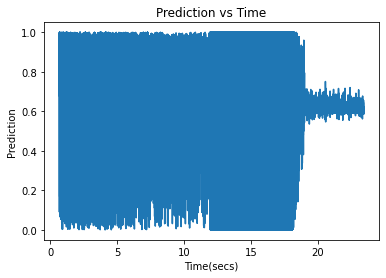

In [ ]:
plot(pred_m1_e2,Exp2_10_t)

Exp3 Plots

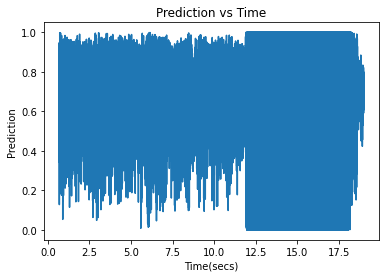

In [ ]:
plot(pred_m1_e3,Exp3_10_t)

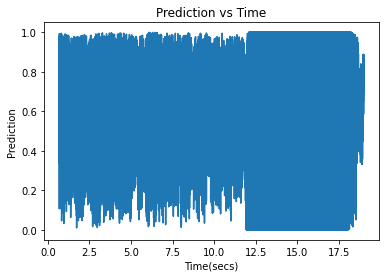

In [ ]:
plot(pred_m2_e3,Exp3_10_t)

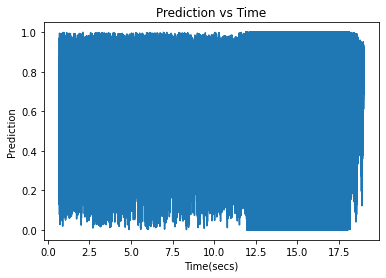

In [ ]:
plot(pred_m3_e3,Exp3_10_t)

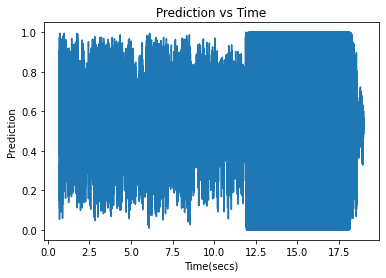

In [ ]:
plot(pred_m4_e3,Exp3_10_t)

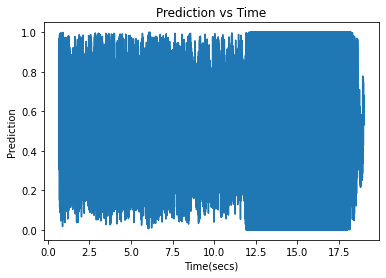

In [ ]:
plot(pred_m5_e3,Exp3_10_t)

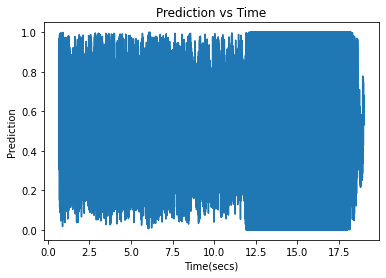

In [ ]:
plot(pred_m5_e3,Exp3_10_t)